In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
import os
import shutil
import glob
import re

import numpy as np

# import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.mlab as mlab

from matplotlib import rc
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
total_time_pattern = r'Processing (?P<slide_id>\d+) done in (?P<slide_time>\d+\.\d+)s'
fps_pattern = r'(?P<n_tiles>\d+) Tiles preloaded in (?P<load_time>\d+\.\d{3})s CNN finished in (?P<cnn_time>\d+\.\d{3})s'
# tissue_area_pattern = r'Found (?P<n_tiles>\d+) foreground candidates\nProcessing (?P<res>\d+)x'
tissue_area_pattern = r'Processing (?P<res>\d+)x\n.+\nUsing (?P<n_tiles>\d+) tile coordinates'

loss_pattern = r"Iteration (?P<iter_num>\d+),.+loss = (?P<loss_val>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
train_iter_pattern = r"Iteration (?P<iter_num>\d+), lr ="
train_loss_pattern = r"Train net output #\d: loss = (?P<accuracy>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
test_pattern = [r"Iteration (?P<iter_num>\d+), Testing net",
                r"Test net output #0: accuracy = (?P<accuracy>[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",]

# Tissue area

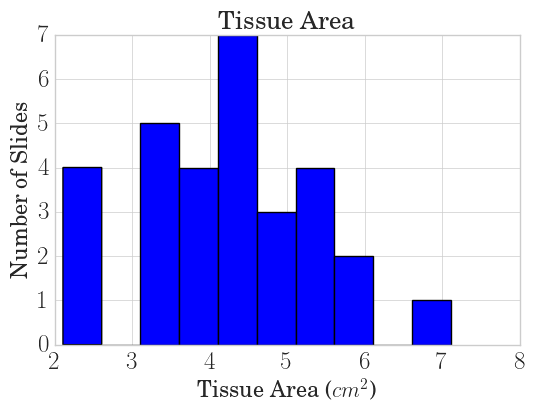

In [25]:
process_log = '/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_fcn8s.txt'
saveto = '/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/inference_time'


with open(process_log, 'r') as f:
    log = f.read()

tissue_areas_10x = []
tissue_areas_5x = []
for r in re.findall(tissue_area_pattern, log):
    n_tiles = float(r[1])
    res = r[0]
    if res == '10':
        tissue_areas_10x.append(n_tiles)
#     elif res == '5':
#         tissue_areas_5x.append(n_tiles)

# Conversion to cm^2
tissue_area = [(256**2 * n_tiles) * (1e-4)**2 for n_tiles in tissue_areas_10x]

fig, ax = plt.subplots(1,1)
ax.tick_params(axis='both', which='major', labelsize=18)
_, bins, _ = ax.hist(tissue_area)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Tissue Area ($cm^2$)', size=16)
ax.set_ylabel('Number of Slides', size=16)
ax.set_title('Tissue Area', size=18)


outpath = os.path.join(saveto, 'slide_areas.pdf')
fig.savefig(outpath, bbox_inches='tight')


# Training Curves

LOG: /Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet/caffe.nathan-workstation.nathan.log.INFO.20170717-145337.32376
Found 150 entries for train iter
Found 150 entries for train loss
Found 16 entries for test iter
Found 16 entries for test acc
Plotting raw values

LOG: /Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet_basic/caffe.nathan-workstation.nathan.log.INFO.20170712-174628.11962
Found 1307 entries for train iter
Found 1307 entries for train loss
Found 66 entries for test iter
Found 66 entries for test acc
Plotting raw values

LOG: /Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/FCN8s/caffe.maz.maz.log.INFO.20170711-153921.14799
Found 241 entries for train iter
Found 241 entries for train loss
Found 31 entries for test iter
Found 31 entries for test acc
Plotting raw values



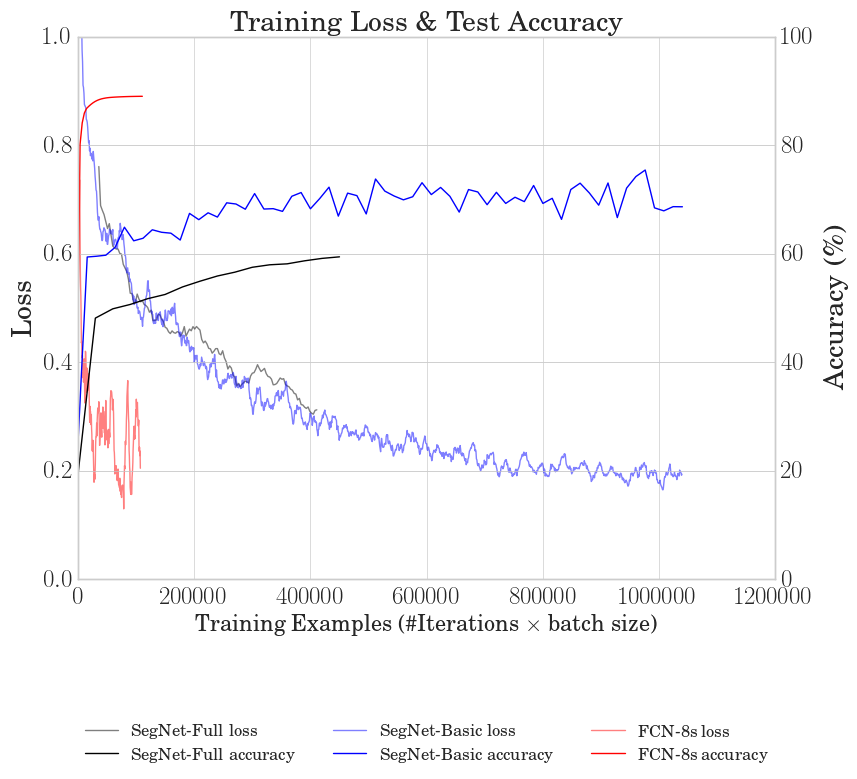

In [27]:
logs = ['/Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet/caffe.nathan-workstation.nathan.log.INFO.20170717-145337.32376',
        '/Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_1024/segnet_basic/caffe.nathan-workstation.nathan.log.INFO.20170712-174628.11962',
        '/Users/nathaning/Dropbox/projects/semantic_pca/log_performance/log/FCN8s/caffe.maz.maz.log.INFO.20170711-153921.14799']

# logs = ['/home/nathan/Dropbox/projects/semantic_pca/log_performance/log/xval_set_1_512/segnet/caffe.nathan-workstation.nathan.log.INFO.20170723-135745.10782',
#         '/home/nathan/Dropbox/projects/semantic_pca/log_performance/log/xval_set_0_512/segnet_basic/caffe.nathan-workstation.nathan.log.INFO.20170712-174629.11974',
#         '/home/nathan/Dropbox/projects/semantic_pca/log_performance/log/FCN8s/caffe.maz.maz.log.INFO.20170711-153921.14799']

colors = ['k', 'b', 'r']
smoothing = [25, 15, 15]
names = ['SegNet-Full', 'SegNet-Basic', 'FCN-8s']
batch_sizes = [6, 16, 1]
legend_names = ['Train Loss', 'Test Accuracy']

def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Set up plot:
fig, ax1 = plt.subplots(figsize=(9,7))
ax1.tick_params(axis='both', which='major', labelsize=18)
# ax1.set_facecolor('white')
ax2 = ax1.twinx()
ax2.tick_params(axis='both', which='major', labelsize=18)
# ax1.set_xlabel(r'Examples (Iterations $\times$ Batch Size)', size=16)

# ax1.set_xlabel(r'SGD Updates (\#Iterations)', size=20)
ax1.set_xlabel(r'Training Examples (\#Iterations $\times$ batch size)', size=16)
ax1.set_ylabel(r'Loss', size=20)
ax2.set_ylabel(r'Accuracy (\%)', size=20)


ax1.set_ylim([0,1])
ax2.set_ylim([0,100])
# ax1.spines['top'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax1.yaxis.set_ticks_position('left')
# ax1.xaxis.set_ticks_position('bottom')

handles = []


for logfile, color, name, batchsize, smooth in zip(logs, colors, names, batch_sizes, smoothing):
    print 'LOG: {}'.format(logfile)
    with open(logfile, 'r') as f:
        log = f.read()

    train_iter = []
    train_loss = []

    for r in re.findall(train_iter_pattern, log):
        train_iter.append(float(r))
    print 'Found {} entries for train iter'.format(len(train_iter))

    for r in re.findall(train_loss_pattern, log):
        train_loss.append(float(r[0]))
    print 'Found {} entries for train loss'.format(len(train_loss))

    # Test patterns
    test_iter = []
    for r in re.findall(test_pattern[0], log):
        test_iter.append(r)
    print 'Found {} entries for test iter'.format(len(test_iter))

    test_acc = []
    for r in re.findall(test_pattern[1], log):
        test_acc.append(float(r[0]) * 100.)
    print 'Found {} entries for test acc'.format(len(test_acc))
    
#     test_loss = []
#     for r in re.findall(test_pattern[2], log):
#         test_loss.append(float(r[0]) * 100.)
#     print 'Found {} entries for test loss'.format(len(test_loss))
#     print test_loss

    train_iter = np.asarray(train_iter, dtype=np.float) * batchsize
    train_loss = np.asarray(train_loss, dtype=np.float)
    test_iter = np.asarray(test_iter, dtype=np.float) * batchsize
    test_acc = np.asarray(test_acc, dtype=np.float)
#     test_loss = np.asarray(test_loss, dtype=np.float)
#     test_loss /= test_loss.max()

    if moving_average:
        train_iter = moving_average(train_iter, n=smooth)
        train_loss = moving_average(train_loss, n=smooth)
#         test_iter = moving_average(test_iter, n=1)
#         test_acc = moving_average(test_acc, n=1)
#         test_loss = moving_average(test_loss, n=1)


    print "Plotting raw values"
    ax1.plot(train_iter, train_loss, color = color, linestyle = '-', alpha=0.5)
#     ax1.plot(test_iter, test_loss, color = color, linestyle = '-.')
    ax2.plot(test_iter, test_acc, color = color) 

#     if log_scale:
#         print "Plotting iterations in Log scale"
#         ax1.set_xscale('log')

    handles += [mlines.Line2D([], [], color=color, label=name+' loss', linestyle = '-', alpha=0.5),
#                 mlines.Line2D([], [], color=color, label=name+' test loss', linestyle = '-.'),
               mlines.Line2D([], [], color=color, label=name+' accuracy'),]
    print ''

lgd = plt.legend(loc=8,
           bbox_to_anchor=(0, -0.35, 1, -0.5),
           ncol=3, mode="expand", borderaxespad=0.,
           handles=handles)

plt.title('Training Loss \& Test Accuracy', size=20)
# fig.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/loss_plots/plots_nexamples.pdf',
#             bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# Time for one net

Found 29 entries for slide time


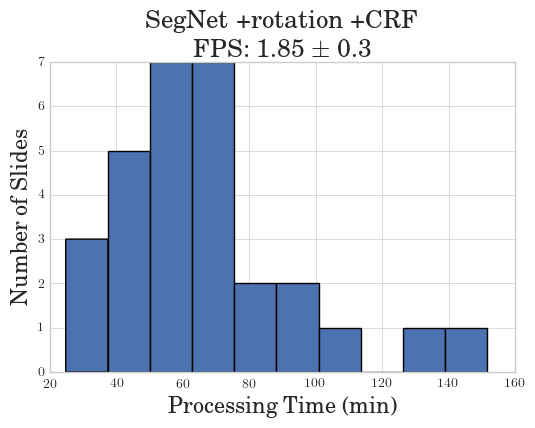

In [10]:
process_log = '/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_fcn8s.txt'
title = 'SegNet +rotation +CRF'
saveto = '/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/inference_time'

total_time_pattern = r'Processing (?P<slide_id>\d+) done in (?P<slide_time>\d+\.\d+)s'
fps_pattern = r'(?P<n_tiles>\d+) Tiles preloaded in (?P<load_time>\d+\.\d{3})s CNN finished in (?P<cnn_time>\d+\.\d{3})s'
# tissue_area_pattern = r'Found (?P<n_tiles>\d+) foreground candidates\nProcessing (?P<res>\d+)x'
tissue_area_pattern = r'Processing (?P<res>\d+)x\nUsing (?P<n_tiles>\d+) tile coordinates'
# total_time_pattern = r'Reconstructing'

with open(process_log, 'r') as f:
    log = f.read()

slide_times = []
for r in re.findall(total_time_pattern, log):
    slide_times.append(float(r[1])/60.)
print 'Found {} entries for slide time'.format(len(slide_times))
slide_times = np.asarray(slide_times)

fps = []
for r in re.findall(fps_pattern, log):
    n_tiles = float(r[0])
    cnn_time = float(r[2])
    fps.append(n_tiles / cnn_time)    
fpstr = u'FPS: {:3.2f} $\pm$ {:3.1f}'.format(np.mean(fps), np.std(fps))


fig, ax = plt.subplots(1,1)
ax.hist(slide_times)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Processing Time (min)', size=16)
ax.set_ylabel('Number of Slides', size=16)
ax.set_title(title+'\n'+fpstr, size=18)

outpath = os.path.join(saveto, title+'.pdf')
# fig.savefig(outpath, bbox_inches='tight')


# Use this to plot multiple histograms on one axis:
# https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib

Found 30 entries for slide time
Found 30 entries for slide time
Found 30 entries for slide time
Found 30 entries for slide time


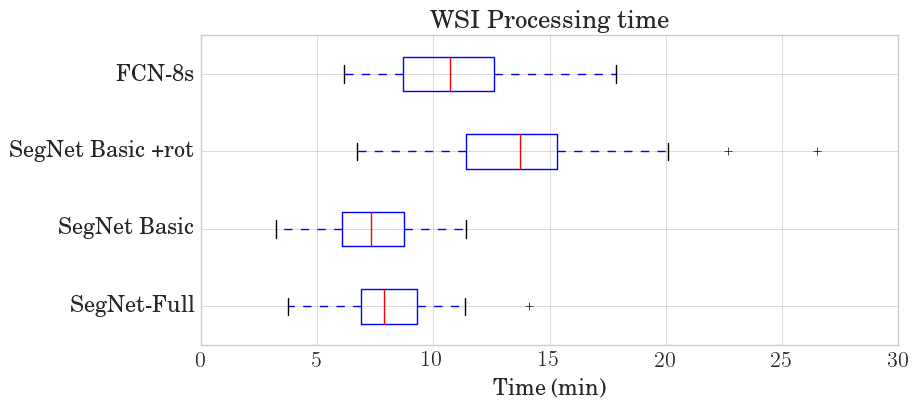

In [26]:
names = ['SegNet-Full',
         'SegNet Basic',
         'SegNet Basic +rot',
#          'SegNet Basic +crf',
         'FCN-8s']
logfiles = ['/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_segnet_full.txt', 
            '/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_segnet_basic.txt',
            '/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_segnet_basic_rotation.txt',
            '/Users/nathaning/Dropbox/projects/semantic_pca/results/reports_logs/log_fcn8s.txt']

n = len(names)
sig = 2

fig, ax = plt.subplots(1,1, figsize=(9,4))
x = []
for name, logf in zip(names, logfiles):
    with open(logf, 'r') as f:
        log = f.read()
    slide_times = []
    for r in re.findall(total_time_pattern, log):
        slide_times.append(float(r[1])/60.)
    print 'Found {} entries for slide time'.format(len(slide_times))
    slide_times = np.asarray(slide_times)
#     ax.hist(slide_times, 10, label = name, alpha=0.3,edgecolor='black',lw=1.5)
    x.append(slide_times)

# ax.hist(x, 10, label = names, stacked=False, alpha=0.8,edgecolor='black')
ax.boxplot(x, vert=False, notch=False)

# sns.boxplot(x, orient="h")

# lgd = ax.legend(loc=8, ncol=n, bbox_to_anchor=(0, -0.4, 1, -0.5))

ax.tick_params(axis='both', which='major', labelsize=16)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time (min)', size=16)
# ax.set_ylabel('Number of Slides', size=16)
ax.set_yticklabels(names)
ax.set_title('WSI Processing time ', size=18)

# fig.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/inference_time/wsi_time.pdf', bbox_inches='tight')

In [29]:
np.mean(x, axis=1)

array([  7.99068278,   7.45030389,  14.01854667,  11.03262556])

In [30]:
(14.01854 - 7.450303) / 14.01854

0.4685393058050268